In [1]:
from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp,fmin,tpe, Trials
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные моделиё
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки
from sklearn import preprocessing
from sklearn import model_selection

%matplotlib inline
plt.style.use('seaborn')

In [2]:
data = pd.read_csv('data/adult.csv')
data.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [3]:
data.isna().sum()

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [5]:
data.describe(include='object')

,workclass,education,marital.status,occupation,relationship,race,sex,native.country,income
count,32561,32561,32561,32561,32561,32561,32561,32561,32561
unique,9,16,7,15,6,5,2,42,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27816,21790,29170,24720


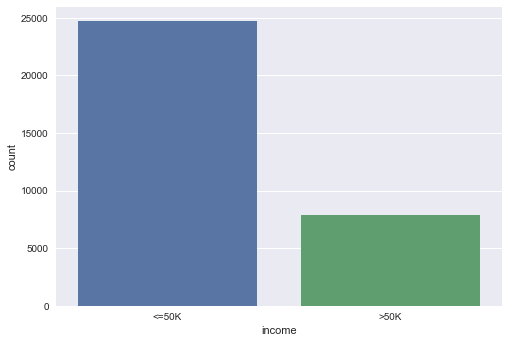

In [6]:
sns.countplot(data = data, x = 'income');

In [7]:
data['income'] = data['income'].apply(lambda x: 1 if x == '>50K' else 0)

In [8]:
cat_features = list(data.select_dtypes(include = 'object').columns)
cat_features

['workclass',
 'education',
 'marital.status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native.country']

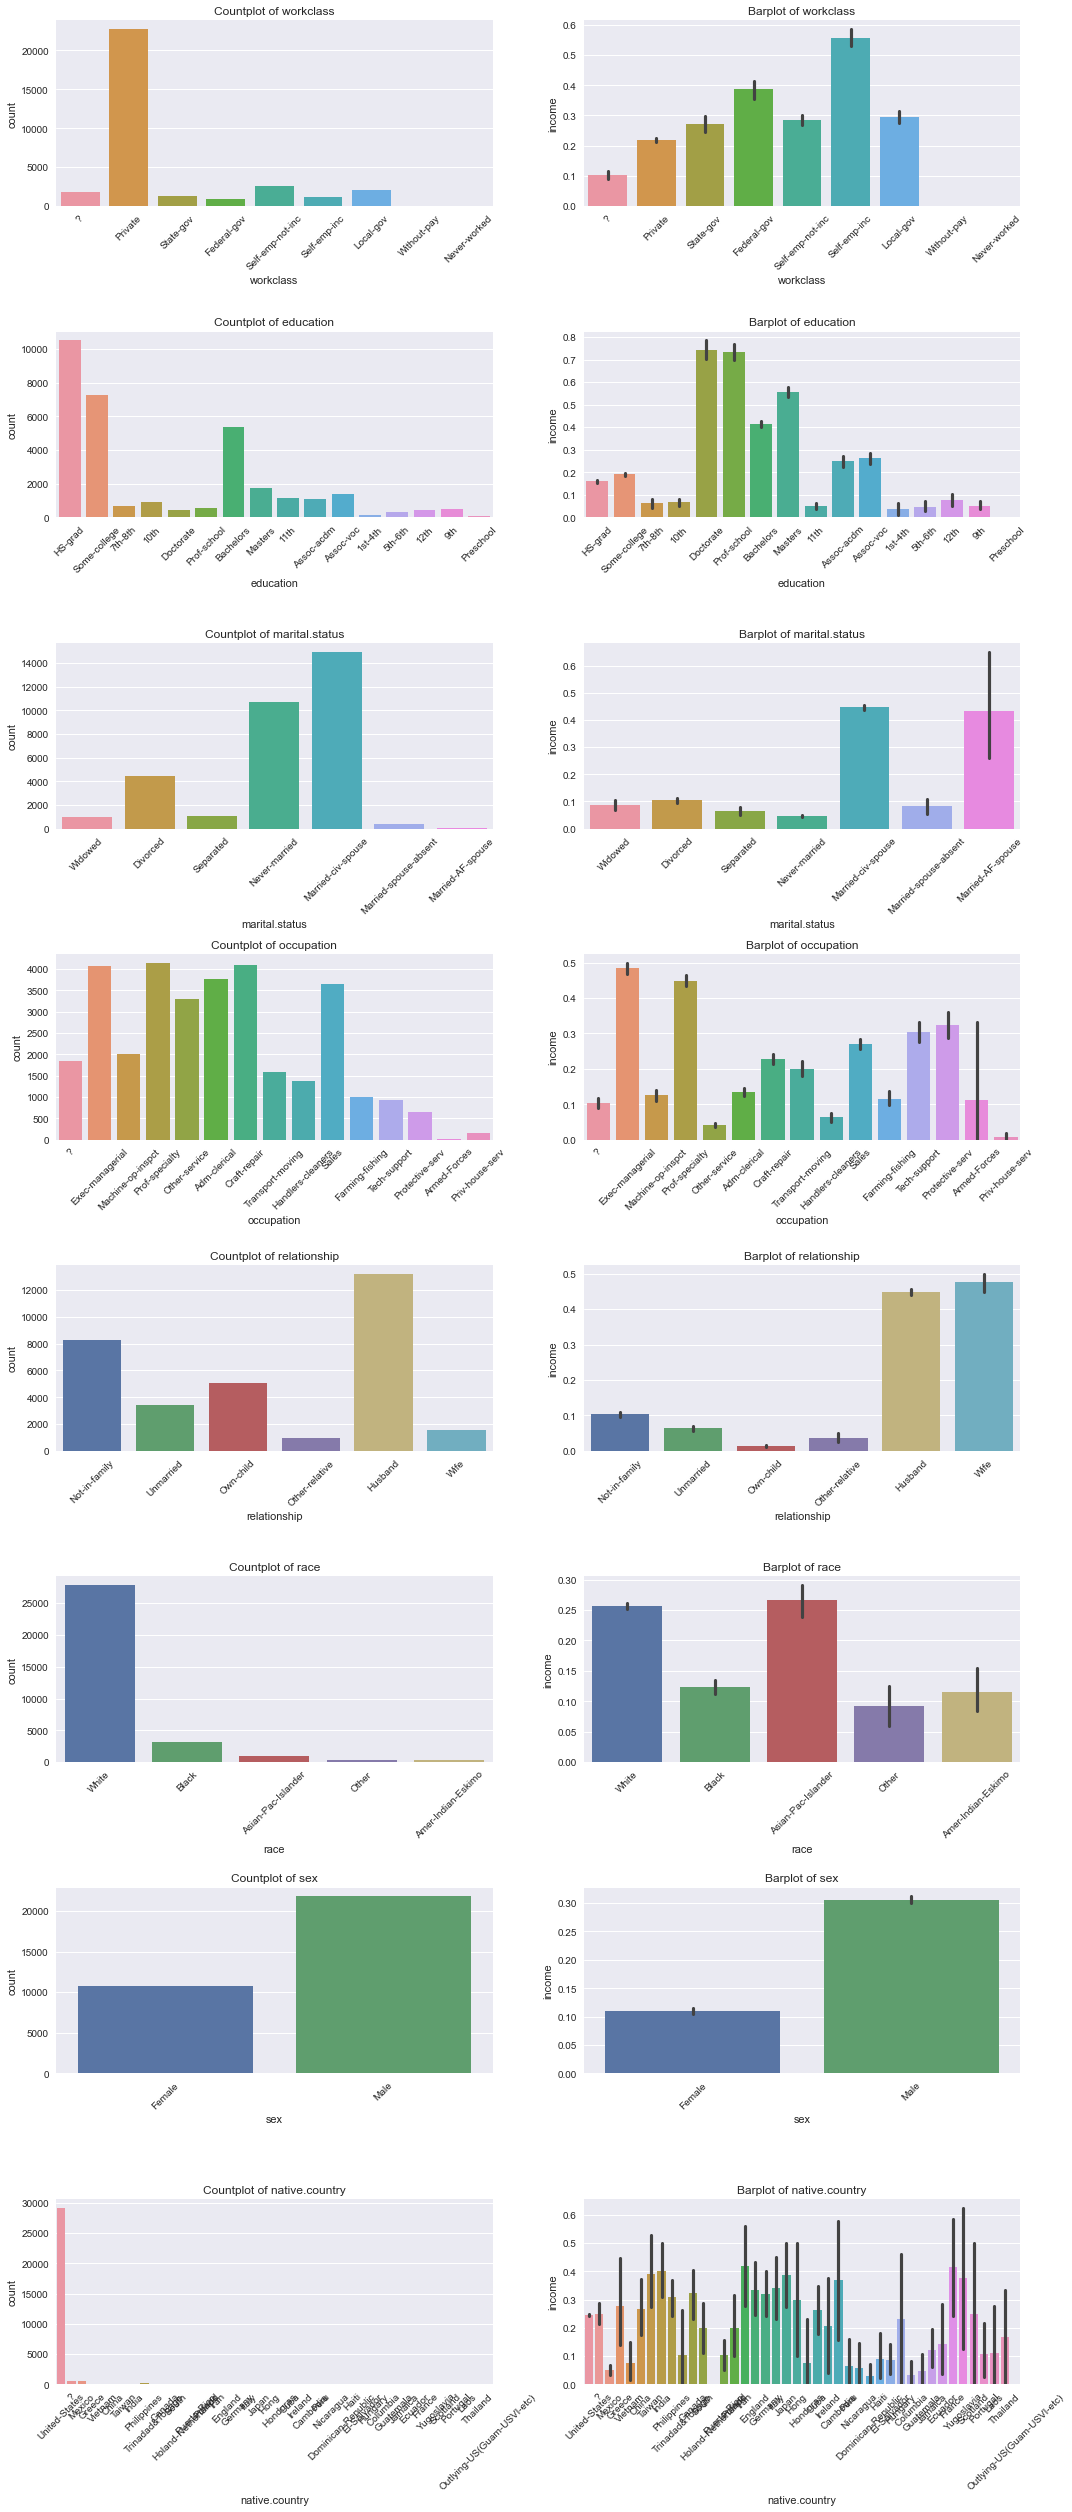

In [9]:
n = len(cat_features)
fig, axes = plt.subplots(n, 2, figsize = (15,35))
for i, feature in enumerate(cat_features):
    countplot = sns.countplot(data = data, x = feature, ax = axes[i][0])
    countplot.set_title(f'Countplot of {feature}')
    countplot.xaxis.set_tick_params(rotation = 45)
    barplot = sns.barplot(data = data, x = feature, y = 'income', ax = axes[i][1])
    barplot.set_title(f'Barplot of {feature}')
    barplot.xaxis.set_tick_params(rotation = 45)
plt.tight_layout()
    

In [10]:
adult_data = data.copy()
#Определяем школьников в отдельную категорию
adult_data['education'] = adult_data['education'].apply(
    lambda x: 'School' if x == '11th' or x == '7th-8th' or x == '10th' 
        or x == '5th-6th' or x == '9th' or x == '12th' or x == '1st-4th' else x
)
#Объединяем категории Assoc-acdm и Assoc-voc (доценты)
adult_data['education'] = adult_data['education'].apply(
    lambda x: 'Associate' if x == 'Assoc-acdm' or x == 'Assoc-voc' else x
)
#Объединяем вдовцов,разведенных и живущих раздельно в одну категорию
adult_data['marital.status'] = adult_data['marital.status'].apply(
    lambda x: 'Prev-Married' if (x == 'Widowed' or x == 'Divorced' or x == 'Separated') else x
)
#Объединяем всех женатых/за мужем в одну категорию
adult_data['marital.status'] = adult_data['marital.status'].apply(
    lambda x: 'Married' if (x == 'Married-civ-spouse' or x == 'Married-spouse-absent' or x == 'Married-AF-spouse') else x
)
#Объединяем мужей и жен в одну категорию, остальных в другую
adult_data['relationship'] = adult_data['relationship'].apply(
    lambda x: 'In relationship' if (x == 'Husband' or x == 'Whife') else 'Not in relationship'
)

#Объединяем типы занятоностей, не приносящих дохода в одну категорию
adult_data['workclass'] = adult_data['workclass'].apply(
    lambda x: 'No income' if x == 'Never-worked' or x == 'Without-pay' else x
)
#Объединяем всех приезжих в одну категорию
adult_data['native.country'] = adult_data['native.country'].apply(
    lambda x: 'Other' if x != 'United-States' else x
)

In [11]:
#Логарифмируем числовые признаки, чтобы придать им форму нормального распределения
adult_data['capital.gain'] = np.log(adult_data['capital.gain']+1)
adult_data['capital.loss'] = np.log(adult_data['capital.loss']+1)
adult_data['fnlwgt'] = np.log(adult_data['fnlwgt']+1)

#Создаем новый признак - разность между приростом капитала и его убылью
adult_data['capital_diff'] = abs((adult_data['capital.gain'] - adult_data['capital.loss']))

In [12]:
#Удаляем лишние признаки
adult_data = adult_data.drop(['education.num', 'capital.gain', 'capital.loss'], axis=1)

In [13]:
adult_data.describe(include='object')
cat_cols = list(adult_data.select_dtypes(include = 'object').columns)

<AxesSubplot:>

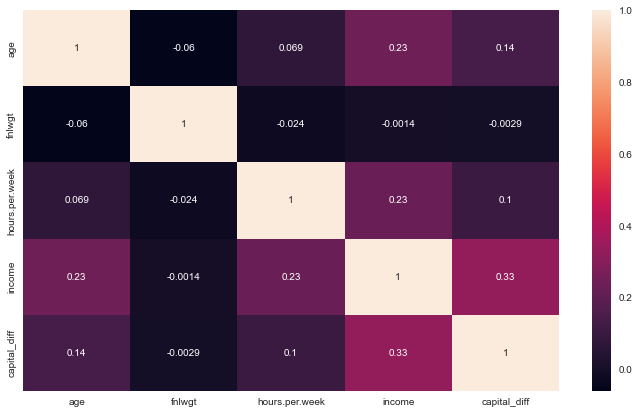

In [14]:
plt.figure(figsize= (12,7))
sns.heatmap(adult_data.corr(), annot= True)

In [15]:
dummies_data = pd.get_dummies(data= adult_data, drop_first=True)
dummies_data.head()
dummies_data.columns

Index(['age', 'fnlwgt', 'hours.per.week', 'income', 'capital_diff',
       'workclass_Federal-gov', 'workclass_Local-gov', 'workclass_No income',
       'workclass_Private', 'workclass_Self-emp-inc',
       'workclass_Self-emp-not-inc', 'workclass_State-gov',
       'education_Bachelors', 'education_Doctorate', 'education_HS-grad',
       'education_Masters', 'education_Preschool', 'education_Prof-school',
       'education_School', 'education_Some-college',
       'marital.status_Never-married', 'marital.status_Prev-Married',
       'occupation_Adm-clerical', 'occupation_Armed-Forces',
       'occupation_Craft-repair', 'occupation_Exec-managerial',
       'occupation_Farming-fishing', 'occupation_Handlers-cleaners',
       'occupation_Machine-op-inspct', 'occupation_Other-service',
       'occupation_Priv-house-serv', 'occupation_Prof-specialty',
       'occupation_Protective-serv', 'occupation_Sales',
       'occupation_Tech-support', 'occupation_Transport-moving',
       'relationsh

In [16]:
X = dummies_data.drop(['income'], axis = 1)
y = dummies_data['income']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify= y, test_size= 0.2, random_state= 1)

In [18]:
MMScaler = preprocessing.MinMaxScaler()
MMScaler.fit(X_train)
X_train_scaled = MMScaler.transform(X_train)
X_test_scaled = MMScaler.transform(X_test)

In [19]:
log_reg = linear_model.LogisticRegression(max_iter= 1000, random_state= 42)
log_reg.fit(X_train_scaled, y_train)
y_test_pred = log_reg.predict(X_test_scaled)
print('Accuracy on our test selection {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print('f1 score on our test selection {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Accuracy on our test selection 0.84
f1 score on our test selection 0.64


In [22]:
import optuna
optuna.__version__
random_state = 42

In [26]:
def optunarf(trial):
      # задаем пространства поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 100, 300, 10)
    max_depth = trial.suggest_int('max_depth', 15, 40, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 3, 7, 1)

    # создаем модель
    model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
     # обучаем модель
    model.fit(X_train_scaled, y_train)
    score = metrics.f1_score(y_train, model.predict(X_train_scaled))

    return score

In [27]:
%%time
study = optuna.create_study(study_name= 'RandomStateClassifier', direction = 'maximize')
study.optimize(optunarf, n_trials = 20)

[I 2022-09-08 20:39:01,320] A new study created in memory with name: RandomStateClassifier
[I 2022-09-08 20:39:03,025] Trial 0 finished with value: 0.7059362403810922 and parameters: {'n_estimators': 110, 'max_depth': 23, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.7059362403810922.
[I 2022-09-08 20:39:06,804] Trial 1 finished with value: 0.7702282618349764 and parameters: {'n_estimators': 240, 'max_depth': 38, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.7702282618349764.
[I 2022-09-08 20:39:10,831] Trial 2 finished with value: 0.7402480675894301 and parameters: {'n_estimators': 280, 'max_depth': 32, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.7702282618349764.
[I 2022-09-08 20:39:12,594] Trial 3 finished with value: 0.7183740430185928 and parameters: {'n_estimators': 130, 'max_depth': 19, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.7702282618349764.
[I 2022-09-08 20:39:15,272] Trial 4 finished with value: 0.6956601861236524 and parameters: {'n_e

CPU times: user 1min 5s, sys: 874 ms, total: 1min 6s
Wall time: 1min 6s


In [28]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 230, 'max_depth': 40, 'min_samples_leaf': 3}
f1_score на обучающем наборе: 0.77


In [29]:
model_best = ensemble.RandomForestClassifier(**study.best_params, random_state = 42)
model_best.fit(X_train_scaled, y_train)
y_pred = model_best.predict(X_test_scaled)
print('f1-score {:.2f}'.format(metrics.f1_score(y_test,y_pred)))

f1-score 0.68
